<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/gds_python/gds_python_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install graphdatascience

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 8.3 MB/s 
  Created wheel for neo4j: filename=neo4j-4.4.3-py3-none-any.whl size=116069 sha256=67391a9792faafefbfecd094cb3b35fa71d2118fee110321f0aa768ff66b3a8b
  Stored in directory: /root/.cache/pip/wheels/db/dd/76/acacd519878f133f2f869aec70db548d89e04013209c3c62bc
Successfully built neo4j


In [3]:
from graphdatascience import GraphDataScience

host = "bolt://35.175.152.65:7687"
user = "neo4j"
password= "roller-agreement-partition"

gds = GraphDataScience(host, auth=(user, password))

In [5]:
# Optionally set different database
gds.set_database("neo4j")

In [6]:
# Check if connection is valid and the target database has GDS installed
print(gds.version())

2.0.1


In [7]:
# run_cypher method allows you to execute any Cypher statement
gds.run_cypher("""
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/HP/hp_1.csv" AS row
MERGE (s:Character {name:row.source})
MERGE (t:Character {name:row.target})
MERGE (s)-[i:INTERACTS]->(t)
SET i.weight = toInteger(row.weight)
""")

""


In [14]:
# When you return records using the run_cypher method, the return is a pandas dataframe
degree_df = gds.run_cypher("""
MATCH (c:Character)
RETURN c.name AS character,
       size((c)--()) AS degree
""")

In [9]:
degree_df.head()

,character,degree
0,Petunia Dursley,8
1,Dudley Dursley,14
2,Lily J. Potter,5
3,James Potter I,5
4,Harry Potter,83


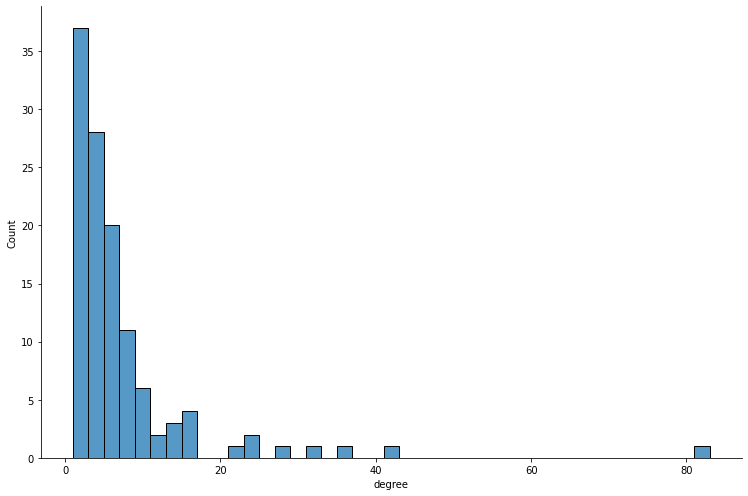

In [10]:
# You can use the df with your favourite third party tools like the SNS
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(data=degree_df, x="degree", height=7, aspect=1.5)

In [12]:
# The main idea behind the graphdatascience library is that it allows you to execute GDS procedures straighforward
# As always, we first have to project an in-memory graph
G, res = gds.graph.project('hp', 'Character', {'INTERACTS': {'orientation': 'UNDIRECTED', 'properties': ['weight']}})

In [13]:
# The res provides metadata about the projected graph and is in form of Pandas Series
res

nodeProjection            {'Character': {'label': 'Character', 'properti...
relationshipProjection    {'INTERACTS': {'orientation': 'UNDIRECTED', 'a...
graphName                                                                hp
nodeCount                                                               119
relationshipCount                                                       812
projectMillis                                                            21
Name: 0, dtype: object

In [15]:
# The graph object provides a couple of method, learn more at: https://neo4j.com/docs/graph-data-science/current/python-client/graph-object/
G.name()

'hp'

In [16]:
G.density()

0.05782652043868395

In [17]:
G.memory_usage()

'2341 KiB'

In [18]:
G.relationship_properties('INTERACTS')

['weight']

In [19]:
# Shortest path algorithms
# The input to a shortest path algorithm needs the internal node id of a source and target node
source_id = gds.find_node_id(["Character"], {"name": "Harry Potter"})
target_id = gds.find_node_id(["Character"], {"name": "Helena Ravenclaw"})


In [32]:
# The first argument to any algorithm is the graph object, followed by optional configuration parameters, which can be provided as keyword arguments
shortestPathResult = gds.shortestPath.dijkstra.stream(G, sourceNode=source_id, targetNode=target_id, relationshipWeightProperty='weight')


In [21]:
shortestPathResult

,index,sourceNode,targetNode,totalCost,nodeIds,costs,path
0,0,4,104,3.0,"[4, 46, 6, 104]","[0.0, 1.0, 2.0, 3.0]","((cost), (cost), (cost))"


In [31]:
# The Path is returned as a Neo4j Driver Path object:
# https://neo4j.com/docs/api/python-driver/current/api.html#neo4j.graph.Path
totalCost = 0
for rel in shortestPathResult['path'][0]:
  totalCost += rel['cost']
  print(f"The traversal from {rel.start_node['name']} to {rel.end_node['name']} costs {rel['cost']}, totalling {totalCost}")

The traversal from Harry Potter to Circe costs 1.0, totalling 1.0
The traversal from Circe to Albus Dumbledore costs 1.0, totalling 2.0
The traversal from Albus Dumbledore to Helena Ravenclaw costs 1.0, totalling 3.0


In [33]:
# PageRank stream
pageRankResult = gds.pageRank.stream(G, relationshipWeightProperty='weight')

In [34]:
pageRankResult.head()

,nodeId,score
0,0,1.851142
1,1,3.241780
2,2,0.375610
3,3,0.375610
4,4,24.197442


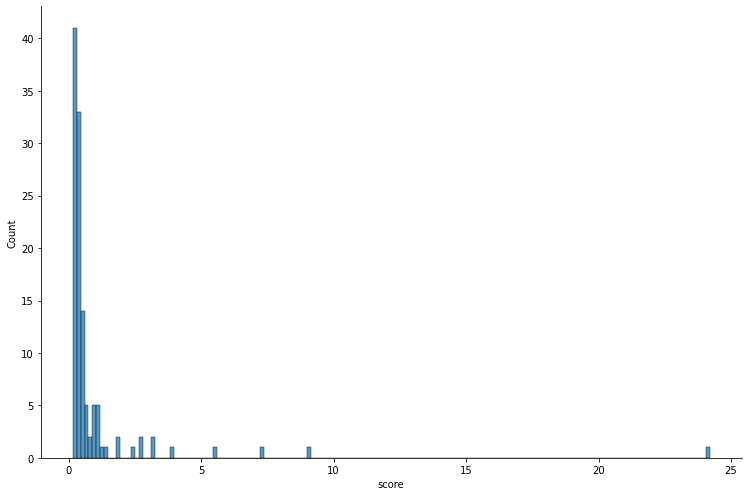

In [35]:
sns.displot(data=pageRankResult, x="score", height=7, aspect=1.5)

In [36]:
# If you need to fetch information about node objects based on their internal node ids, you can use gds.util.asNodes
pageRankResult['node_object'] =  gds.util.asNodes(pageRankResult['nodeId'].to_list())
pageRankResult['name'] = [n['name'] for n in pageRankResult['node_object']]

In [37]:
pageRankResult.head()

,nodeId,score,node_object,name
0,0,1.851142,(name),Petunia Dursley
1,1,3.241780,(name),Dudley Dursley
2,2,0.375610,(name),Lily J. Potter
3,3,0.375610,(name),James Potter I
4,4,24.197442,(name),Harry Potter


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

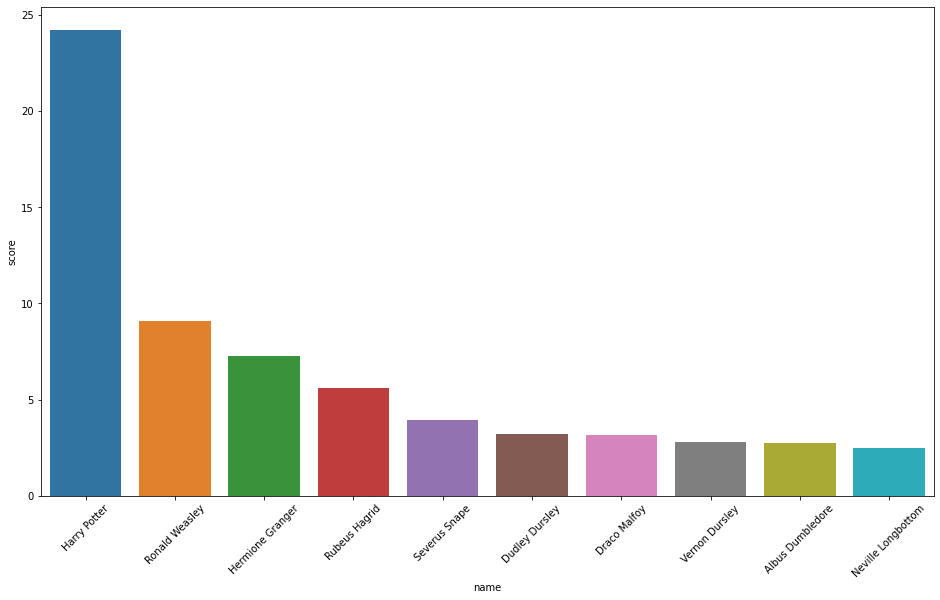

In [38]:
plt.figure(figsize=(16,9))
sns.barplot(x='name', y='score', data=pageRankResult.sort_values(by='score', ascending=False).head(10))
plt.xticks(rotation=45)

In [39]:
# Louvain mutate
louvain_stats = gds.louvain.mutate(G, mutateProperty='communityId', relationshipWeightProperty='weight')

In [40]:
# Since we ran the mutate mode, only the metadata or the stats of the algorithm are returned
louvain_stats

mutateMillis                                                             0
nodePropertiesWritten                                                  119
modularity                                                        0.176974
modularities                    [0.15405649883268652, 0.17697414179849225]
ranLevels                                                                2
communityCount                                                          10
communityDistribution    {'p99': 42, 'min': 2, 'max': 42, 'mean': 11.9,...
postProcessingMillis                                                     2
preProcessingMillis                                                      0
computeMillis                                                         1537
configuration            {'maxIterations': 10, 'seedProperty': None, 'c...
Name: 0, dtype: object

In [46]:
G.node_properties('Character')

['communityId']

In [41]:
# If you want to retrieve node properties from the in-memory graph in the form of a Pandas DataFrame
louvain_values = gds.graph.streamNodeProperty(G, 'communityId')

In [42]:
louvain_values.head()

,nodeId,propertyValue
0,0,103
1,1,103
2,2,3
3,3,3
4,4,14


In [43]:
# Rename columns
louvain_values.columns = ['nodeId', 'communityId']

In [44]:
# You can do all sorts of pandas operations
louvain_values.groupby('communityId').size().to_frame('communitySize').reset_index().sort_values(by=['communitySize'], ascending=False)

,communityId,communitySize
2,14,42
8,103,18
7,99,16
5,69,11
3,31,8
1,4,7
4,48,6
6,81,5
9,117,4
0,3,2


In [49]:
# We can now do subgraph filtering to use only the largest community
largest_community_graph, result = gds.beta.graph.project.subgraph('largest_community', G, 'n.communityId = 14', '*')

In [50]:
result

fromGraphName                         hp
nodeFilter            n.communityId = 14
relationshipFilter                     *
graphName              largest_community
nodeCount                             42
relationshipCount                    240
projectMillis                         64
Name: 0, dtype: object

In [51]:
largest_community_graph.memory_usage()

'2372 KiB'

In [52]:
# You can use python client in your ML workflow
embeddings = gds.fastRP.stream(largest_community_graph, embeddingDimension=56)

In [53]:
embeddings.head()

,nodeId,embedding
0,4,"[0.5925194025039673, 0.2690800428390503, 0.237..."
1,6,"[0.6302388906478882, 0.4231761693954468, 0.172..."
2,7,"[0.4501940608024597, 0.2033696174621582, 0.146..."
3,9,"[0.612358808517456, 0.3847566843032837, 0.2185..."
4,13,"[0.5957857370376587, 0.30359897017478943, 0.22..."


In [60]:
embeddings['name'] = [n['name'] for n in gds.util.asNodes(embeddings['nodeId'].to_list())]

In [61]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns

def tsne(embeddings, hue=None):
    tsne = TSNE(n_components=2, n_iter=300)
    tsne_results = tsne.fit_transform(embeddings['embedding'].to_list())

    embeddings['tsne_x'] = [x[0] for x in list(tsne_results)]
    embeddings['tsne_y'] = [x[1] for x in list(tsne_results)]

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne_x", y="tsne_y",
        hue=hue,
        palette="deep",
        data=embeddings,
        legend="full",
        alpha=0.9)
    # Add captions
    for i in range(embeddings.shape[0]):
        plt.text(x=embeddings['tsne_x'][i]+0.3,y=embeddings['tsne_y'][i]+0.3,s=embeddings.name[i], 
              fontdict=dict(color='black',size=10),)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


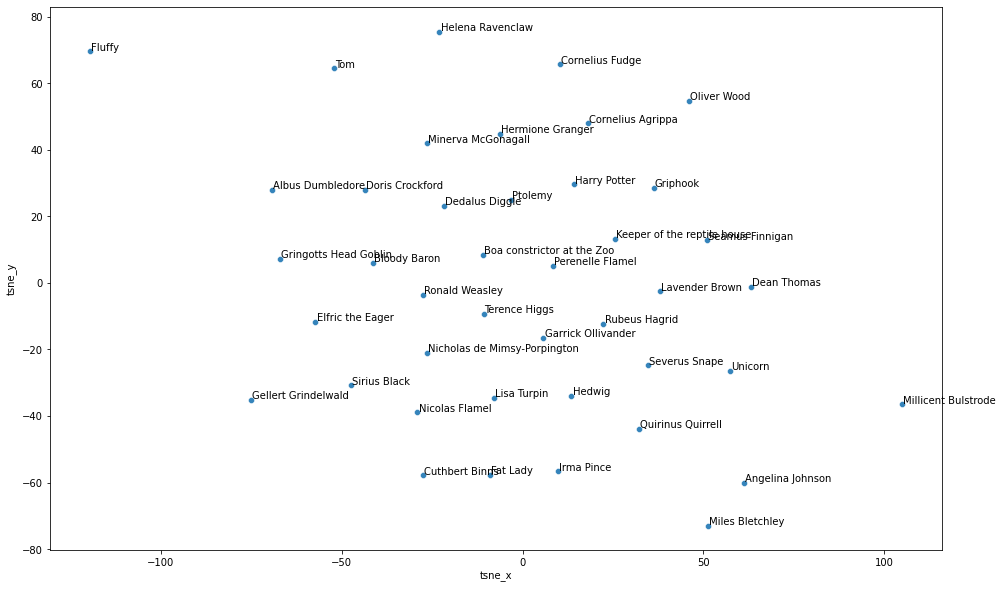

In [62]:
tsne(embeddings)

In [63]:
# Drop a projected in-memory graph
G.drop()